# Prototype Dataset
This file generates the path-to-path dataset to train a prototype transformer

The input output sequence of a logo should consist of 270 Parameters
- DeepSVG Embedding (256)
- a0 Type "EOS" (1)
- a1 - a6 Type (6)
- a7 - a12 Param (6)
- a13 time offset from beginning of animation in seconds

Input Sequence
- In the input sequence, the last 13 Parameters are set to zero
- In a final model, these parameters are aimed to be left out (as context vector isn't based on that)

Output Sequence
- The Output sequence consists of the selected paths represented by their DeepSVG Embedding
- The Animation is represented through the type and the parameters.
- Each output sequence ends with an EOS Token, where the EOS-type in the one-hot-encoded part is set to 1.

## Creating the input data

In [1]:
import pandas as pd
import firebase_admin
from firebase_admin import credentials, firestore

# Initialize Firebase Admin SDK with your service account credentials
cred = credentials.Certificate("rate-logos-firebase-adminsdk-9tvce-74b6eadb1d.json")
firebase_admin.initialize_app(cred)

# Create a reference to the Firestore database
db = firestore.client()

# Reference to your Firestore collection
collection_ref = db.collection("animations_new")

# Get documents from the collection
documents = collection_ref.stream()

# Create a list to store data
data = []

# Iterate over documents and extract data
for doc in documents:
    data.append(doc.to_dict())

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Display the DataFrame
print(df)
df.to_csv('data/ratings/test_rating.csv', index=False)

      rating alias       filename    id                             time  \
0          4           logo_0.svg     0 2024-02-28 20:37:35.310000+00:00   
1          0        logo_3555.svg     1 2024-02-28 20:38:55.975000+00:00   
2          0        logo_4597.svg    10 2024-02-28 20:40:17.609000+00:00   
3          0         logo_975.svg   100 2024-02-28 22:35:09.303000+00:00   
4          0        logo_3578.svg  1000 2024-03-01 11:13:04.844000+00:00   
...      ...   ...            ...   ...                              ...   
4176       0        logo_3952.svg   995 2024-03-01 11:12:41.487000+00:00   
4177       0         logo_970.svg   996 2024-03-01 11:12:44.772000+00:00   
4178       0        logo_4944.svg   997 2024-03-01 11:12:48.294000+00:00   
4179       0         logo_149.svg   998 2024-03-01 11:12:53.969000+00:00   
4180       2        logo_3066.svg   999 2024-03-01 11:13:00.958000+00:00   

                                                   data  
0     0,0,0,1,0,0,0,0,0,0,0,0

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests

file_path = 'data/5_svg_embedding/svg_embedding_5000.pkl'

# Open the pickle file for reading in binary mode
with open(file_path, 'rb') as file:
    # Load the data from the pickle file
    data = pickle.load(file)

#filtered_data = pd.read_csv("data/animated_svgs_dataframes/firebase_animations.csv", sep=";").rename(columns={"filename":"file", "rating" : "label"})
#data["filename"]=data["filename"].str.replace(".svg","")
#test = pd.merge(data, filtered_data, left_on="filename", right_on="file", how="inner")

print(data)

   animation_id         0         1         2         3         4         5  \
0             0 -1.479738  1.499942 -0.460764  0.363093 -0.947988 -1.115443   
1             1 -0.198556  0.946851  0.497889 -0.779701 -0.070278 -0.871111   
2             3  0.141129  1.822560  0.397646  0.658561 -1.421428 -1.602260   
3             2  0.989437  0.265804  2.549353  0.695821 -0.884729 -0.079115   
4             5 -0.157587  0.536932  0.361361 -0.021343 -0.385152  0.616863   
..          ...       ...       ...       ...       ...       ...       ...   
4             6 -0.187661  0.401433 -0.100404  0.636203 -0.474901  1.383271   
5             7  0.877559 -1.188825  1.372045 -0.126786 -0.186506 -0.021710   
6             5 -0.833903  0.496440  0.277829  0.364739 -1.040107  0.297266   
7             4 -0.400199  0.921548  0.191972  0.333160 -1.018423 -1.097480   
8             8  0.877559 -1.188825  1.372045 -0.126786 -0.186506 -0.021710   

           6         7         8  ...       247    

In [3]:
# checking the number of paths 

data['filename'].value_counts()
data["filename"]=data["filename"].str.replace(".svg","")

C:\Users\okan2\AppData\Local\Temp\ipykernel_9116\3690324963.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data["filename"]=data["filename"].str.replace(".svg","")


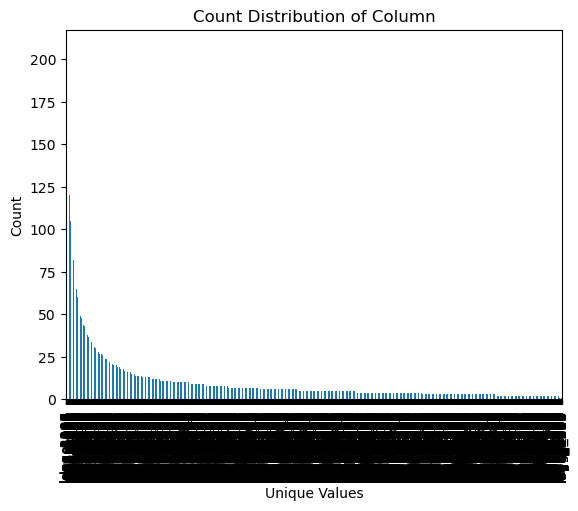

In [4]:
count_distribution = data['filename'].value_counts()
count_distribution.plot(kind='bar')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Count Distribution of Column')
plt.show()

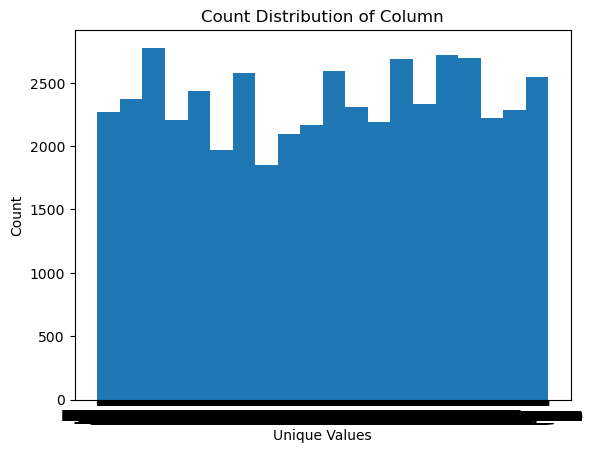

In [5]:
plt.hist(data['filename'], bins=20)  # You can adjust the number of bins as needed
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Count Distribution of Column')
plt.show()

In [6]:
# max number of paths in one logo
data['filename'].value_counts().iloc[0]

207

In [7]:
data[data['filename']=='logo_36']

,animation_id,0,1,2,3,4,5,6,7,8,...,247,248,249,250,251,252,253,254,255,filename
0,0,-1.479738,1.499942,-0.460764,0.363093,-0.947988,-1.115443,1.581553,-0.411030,0.169418,...,1.718861,-0.139440,-1.523274,-1.602520,0.121773,-0.331636,1.083312,1.555735,0.406794,logo_36
1,1,-0.046564,1.268721,0.179297,0.520527,0.102936,0.511308,0.318602,0.652480,-0.204564,...,0.470238,-0.319376,0.230528,0.867940,0.395773,1.336052,0.325830,0.626101,-0.292177,logo_36
2,3,0.078027,-0.885305,0.575409,0.644550,0.071136,1.975846,-0.815557,-0.023037,-0.983261,...,-2.104513,0.376560,1.087818,1.251735,-0.982731,-0.423921,0.295719,-0.759669,-0.560176,logo_36
3,2,0.298474,-1.835696,0.278614,-0.592662,0.103240,0.527570,-0.301879,-0.378880,-0.419961,...,-3.453290,-0.456308,1.361012,0.638535,-0.515345,0.179005,0.714492,-0.504355,-0.210751,logo_36
4,4,0.043930,0.052075,-0.245103,0.936828,-0.281573,1.871222,-1.050934,0.586057,-0.180195,...,-0.875970,-0.431099,0.048782,1.273455,0.410215,-0.542904,0.352429,-1.753664,-0.421086,logo_36


In [8]:
#type(data['animation_id'][118])

In [9]:
# Read CSV into DataFrame
df = pd.read_csv('data/ratings/test_rating.csv')

df['id'] = df.index

# separating to rating and animation
animation_df = df[['id','filename','data', "rating"]]

rating_df = df[['id','filename','rating']]


In [10]:
animation_df

,id,filename,data,rating
0,0,logo_0.svg,"0,0,0,1,0,0,0,0,0,0,0,0,2,-9,17,22,43,0,0,0,0,...",4
1,1,logo_3555.svg,"4,0,1,0,0,0,0,0,0,0,0,1,1,20,-28,16,17,16.4101...",0
2,2,logo_4597.svg,"70,0,0,0,0,0,0,0,0,0,1,0,2,-42,11,-36,4,0.0770...",0
3,3,logo_975.svg,"5,0,0,1,0,0,0,0,0,0,0,3,2,34,42,12,-1,0,0,0,0,...",0
4,4,logo_3578.svg,"2,0,0,0,0,0,0,0,1,0,0,0,5,2,-11,-16,-34,3.3476...",0
...,...,...,...,...
4176,4176,logo_3952.svg,NaN,0
4177,4177,logo_970.svg,"0,0,0,0,0,0,0,0,0,0,1,0,4,45,34,-38,28,8.28508...",0
4178,4178,logo_4944.svg,"0,0,0,0,1,0,0,0,0,0,0,0,3,-44,44,-13,-36,9.192...",0
4179,4179,logo_149.svg,"6,0,0,1,0,0,0,0,0,0,0,0,1,-6,21,17,-45,0,0,0,0...",0


In [11]:
# changing the structure of rating data 

# Split the 'data' column and explode
animation_df['data'] = animation_df['data'].str.rstrip(';').str.split(';')
animation_df = animation_df.explode('data').dropna()

# Reset the index
animation_df.reset_index(drop=True, inplace=True)

# separating the animation ids and animation params
animation_df[['animation_id','a_0','a_1','a_2','a_3','a_4','a_5','a_6','a_7','a_8','a_9',
           'a_10','a_11','a_12','a_13','a_14','a_15','a_16','a_17','a_18','a_19','a_20','a_21',
           'a_22','a_23','a_24','a_25']] = animation_df['data'].str.split(',', expand=True)

animation_df[['animation_id']] = animation_df[['animation_id']].astype(int)

animation_df[['a_0','a_1','a_2','a_3','a_4','a_5','a_6','a_7','a_8','a_9',
           'a_10','a_11','a_12','a_13','a_14','a_15','a_16','a_17','a_18','a_19','a_20','a_21',
           'a_22','a_23','a_24','a_25']] = animation_df[['a_0','a_1','a_2','a_3','a_4','a_5','a_6','a_7','a_8','a_9',
           'a_10','a_11','a_12','a_13','a_14','a_15','a_16','a_17','a_18','a_19','a_20','a_21',
           'a_22','a_23','a_24','a_25']].astype(float)

# Create a new column with concatenated values from each row
animation_df['model_output'] = animation_df[['a_0','a_1','a_2','a_3','a_4','a_5','a_6','a_7','a_8','a_9',
           'a_10','a_11','a_12','a_13','a_14','a_15','a_16','a_17','a_18','a_19','a_20','a_21',
           'a_22','a_23','a_24','a_25']].apply(lambda row: list(row), axis=1)

animation_df.drop(columns=['data','a_0','a_1','a_2','a_3','a_4','a_5','a_6','a_7','a_8','a_9',
           'a_10','a_11','a_12','a_13','a_14','a_15','a_16','a_17','a_18','a_19','a_20','a_21',
           'a_22','a_23','a_24','a_25'], inplace=True)

animation_df.to_csv("data/animated_svgs_dataframes/firebase_animations.csv", sep=";")
animation_df["model_output"] = list(animation_df["model_output"])
animation_df["model_output"]

C:\Users\okan2\AppData\Local\Temp\ipykernel_9116\3409916436.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  animation_df['data'] = animation_df['data'].str.rstrip(';').str.split(';')


0        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
3        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                               ...                        
77968    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
77969    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
77970    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
77971    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
77972    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: model_output, Length: 77973, dtype: object

## PROTOTYPE DATASET START

## Import DeepSVG Embedding

In [12]:
import pickle

import torch

with open("data/5_svg_embedding/svg_embedding_5000.pkl", "rb") as f:
    deepsvg_embedding = pickle.load(f)
deepsvg_embedding["filename"] = deepsvg_embedding["filename"].str.replace(".svg","")

C:\Users\okan2\AppData\Local\Temp\ipykernel_9116\3921990055.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  deepsvg_embedding["filename"] = deepsvg_embedding["filename"].str.replace(".svg","")


In [13]:
## duplicate for further use
embeddings = deepsvg_embedding.copy() #for output sequences
input_sequences = deepsvg_embedding
embeddings.head()

,animation_id,0,1,2,3,4,5,6,7,8,...,247,248,249,250,251,252,253,254,255,filename
0,0,-1.479738,1.499942,-0.460764,0.363093,-0.947988,-1.115443,1.581553,-0.411030,0.169418,...,1.718861,-0.139440,-1.523274,-1.602520,0.121773,-0.331636,1.083312,1.555735,0.406794,logo_2860
1,1,-0.198556,0.946851,0.497889,-0.779701,-0.070278,-0.871111,0.403914,1.100798,-0.337577,...,-2.135782,0.779249,-0.337505,0.429479,-0.411051,2.071597,-0.557817,0.053835,-0.110260,logo_2860
2,3,0.141129,1.822560,0.397646,0.658561,-1.421428,-1.602260,0.216757,0.756272,-1.212852,...,-1.516084,-1.266155,-1.031826,-0.137128,-0.715295,-1.437720,-0.900047,1.734579,2.157370,logo_2860
3,2,0.989437,0.265804,2.549353,0.695821,-0.884729,-0.079115,0.200200,0.758520,-1.034283,...,0.970688,-0.900468,-0.504259,-0.915307,-0.481459,0.234924,-1.022180,1.685095,0.882979,logo_2860
4,5,-0.157587,0.536932,0.361361,-0.021343,-0.385152,0.616863,-0.865314,0.770734,-0.353508,...,-1.172260,0.180234,-0.066151,1.415687,-0.415280,-0.704430,1.124239,-0.776726,0.313482,logo_2860


In [14]:
embeddings['animation_id'] = embeddings['animation_id'].astype(int)
embeddings.head()

,animation_id,0,1,2,3,4,5,6,7,8,...,247,248,249,250,251,252,253,254,255,filename
0,0,-1.479738,1.499942,-0.460764,0.363093,-0.947988,-1.115443,1.581553,-0.411030,0.169418,...,1.718861,-0.139440,-1.523274,-1.602520,0.121773,-0.331636,1.083312,1.555735,0.406794,logo_2860
1,1,-0.198556,0.946851,0.497889,-0.779701,-0.070278,-0.871111,0.403914,1.100798,-0.337577,...,-2.135782,0.779249,-0.337505,0.429479,-0.411051,2.071597,-0.557817,0.053835,-0.110260,logo_2860
2,3,0.141129,1.822560,0.397646,0.658561,-1.421428,-1.602260,0.216757,0.756272,-1.212852,...,-1.516084,-1.266155,-1.031826,-0.137128,-0.715295,-1.437720,-0.900047,1.734579,2.157370,logo_2860
3,2,0.989437,0.265804,2.549353,0.695821,-0.884729,-0.079115,0.200200,0.758520,-1.034283,...,0.970688,-0.900468,-0.504259,-0.915307,-0.481459,0.234924,-1.022180,1.685095,0.882979,logo_2860
4,5,-0.157587,0.536932,0.361361,-0.021343,-0.385152,0.616863,-0.865314,0.770734,-0.353508,...,-1.172260,0.180234,-0.066151,1.415687,-0.415280,-0.704430,1.124239,-0.776726,0.313482,logo_2860


## Train / Test Split

### Logo Dataset Analysis
Most logos have only a few paths
Some logos have over 100 paths to animate

In [15]:
# Might not execute
# input_sequences['filename'].value_counts().hist(bins=100)

### Stratify on Number of Paths in Logo

In [16]:
# Count occurrences
logos = input_sequences.groupby('filename').size().reset_index(name='count')

# To stratify later, categorize the sizes
bins = 20
quantiles = [(i+1)/bins for i in range(bins)]
print(quantiles)

percentiles = logos['count'].quantile(quantiles)
print(percentiles)

# Function to categorize based on quantiles
def categorize_count(count):
    for i, percentile in enumerate(percentiles):
        if count <= percentile:
            return f"Quantile {i}"
    return f"Quantile {len(quantiles)}"

# Apply the categorization function to create a new column
logos['count_category'] = logos['count'].apply(categorize_count)
logos['count_category'].value_counts()

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
0.05      2.0
0.10      2.0
0.15      3.0
0.20      3.0
0.25      3.0
0.30      4.0
0.35      4.0
0.40      4.0
0.45      5.0
0.50      5.0
0.55      6.0
0.60      6.0
0.65      7.0
0.70      8.0
0.75      9.0
0.80     11.0
0.85     14.0
0.90     20.0
0.95     35.0
1.00    207.0
Name: count, dtype: float64


Quantile 2     686
Quantile 5     621
Quantile 0     615
Quantile 8     514
Quantile 10    370
Quantile 12    295
Quantile 15    272
Quantile 16    225
Quantile 19    225
Quantile 13    222
Quantile 17    211
Quantile 18    209
Quantile 14    137
Name: count_category, dtype: int64

### Train / Test split

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split the DataFrame into training and testing sets, stratifying on 'count_category'
logos_train, logos_test = train_test_split(logos, test_size=0.2, stratify=logos['count_category'], random_state=42)

The distributions of lenghts are now similar. Outliers with a long sequence are in both datasets

<Axes: >

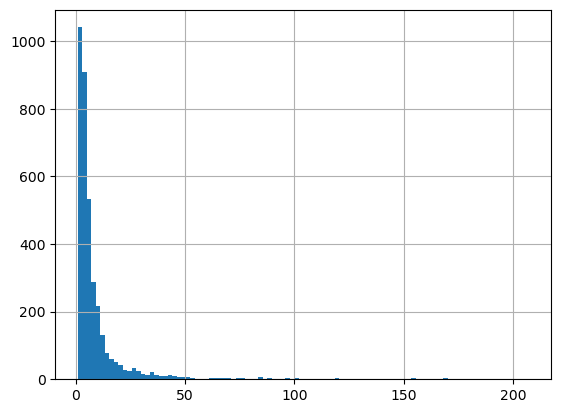

In [18]:
logos_train['count'].hist(bins=100)

<Axes: >

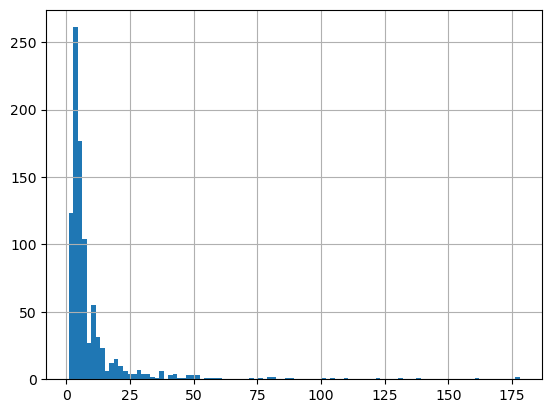

In [19]:
logos_test['count'].hist(bins=100)

In [20]:
logos_test = logos_test['filename'].unique()
logos_train = logos_train['filename'].unique()
logos_test

array(['logo_2889', 'logo_4324', 'logo_566', 'logo_2659', 'logo_2077',
       'logo_285', 'logo_3528', 'logo_764', 'logo_4486', 'logo_2306',
       'logo_3748', 'logo_2267', 'logo_4250', 'logo_4814', 'logo_2917',
       'logo_4154', 'logo_3066', 'logo_844', 'logo_2966', 'logo_2383',
       'logo_3328', 'logo_1517', 'logo_629', 'logo_3261', 'logo_3700',
       'logo_813', 'logo_4370', 'logo_1541', 'logo_4714', 'logo_3210',
       'logo_2539', 'logo_4114', 'logo_4496', 'logo_1286', 'logo_1394',
       'logo_3577', 'logo_690', 'logo_4124', 'logo_504', 'logo_3832',
       'logo_2800', 'logo_3947', 'logo_1139', 'logo_4334', 'logo_2862',
       'logo_2384', 'logo_554', 'logo_4568', 'logo_1631', 'logo_3631',
       'logo_1918', 'logo_4586', 'logo_2895', 'logo_1090', 'logo_4748',
       'logo_3606', 'logo_4189', 'logo_2228', 'logo_777', 'logo_1356',
       'logo_3353', 'logo_461', 'logo_2229', 'logo_1783', 'logo_4738',
       'logo_996', 'logo_4861', 'logo_2148', 'logo_1418', 'logo_4546',
    

### Discussion
- One might also stratify over used animation types.
- Are there enough good animations in the dataset for logos with lots of paths? -> Manual annotation

## Animation Dataset

In [21]:
import pickle
import pandas as pd

# Load the pickle file
with open("data/surrogate_model/animation_label.pkl", "rb") as f:
    imported_pickle = pickle.load(f)

# Create a DataFrame from the imported data
filtered_data = pd.DataFrame(imported_pickle, columns=["file", "animation_id", "model_output", "label"])

filtered_data = pd.read_csv("data/animated_svgs_dataframes/firebase_animations.csv", sep=";").rename(columns={"filename":"file", "rating" : "label"})

# Define the mapping for ratings
#mapping_dict = {"Very Good": 6, "Good": 5, "Okay": 4, "Bad": 3, "Very Bad": 2, "no_rating": 1}
# Replace the 'label' column with the corresponding ratings using .map
#filtered_data['rating'] = filtered_data['label'].map(mapping_dict)
filtered_data['rating'] = filtered_data['label']

filtered_data["file"] = filtered_data["file"].str.replace(".svg","")
# Extract unique logos by splitting 'file' with "_animation" and using .str.get(0)
#logos_unique = filtered_data['file'].str.split('_animation').str.get(0).unique()

C:\Users\okan2\AppData\Local\Temp\ipykernel_9116\2354969405.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  filtered_data["file"] = filtered_data["file"].str.replace(".svg","")


In [22]:
#example
filtered_data[filtered_data["file"].str.contains("logo_5")]

,Unnamed: 0,id,file,label,animation_id,model_output,rating
1796,1796,41,logo_52,3,1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
2091,2091,107,logo_535,0,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0
2092,2092,107,logo_535,0,3,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2093,2093,107,logo_535,0,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0
2094,2094,107,logo_535,0,19,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...,...,...
76466,76466,4027,logo_530,4,4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
76467,76467,4027,logo_530,4,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
76927,76927,4038,logo_566,4,0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
77025,77025,4053,logo_560,4,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4


### Consistency: Delete twice animated paths in one animation
Every animation should animate each path only once. **But there are duplicates.**
Some duplicates are completely equal.

In [23]:
# Example
filtered_data[filtered_data['file'] == "logo_379_animation_5"]
filtered_data.head()

,Unnamed: 0,id,file,label,animation_id,model_output,rating
0,0,0,logo_0,4,0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
1,1,0,logo_0,4,3,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
2,2,0,logo_0,4,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",4
3,3,0,logo_0,4,0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
4,4,1,logo_3555,0,4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [24]:
# SIMPLE DUPLICATE REDUCTION
print(f"There are {filtered_data.duplicated(subset=['file', 'animation_id'], keep=False).sum()} duplicates.")

# Create a copy for and convert numpy to strings
duplicate_search = filtered_data.copy()
duplicate_search['model_output'] = duplicate_search['model_output'].apply(lambda x: str(x))

# Find duplicates in the copy and remove with a mask
duplicates_mask = duplicate_search.duplicated(keep='first')
filtered_data = filtered_data[~duplicates_mask]

filtered_data = filtered_data.drop_duplicates()
print(f"Reduced to {filtered_data.duplicated(subset=['file', 'animation_id'], keep=False).sum()} duplicates.")

There are 65761 duplicates.
Reduced to 65761 duplicates.


But there are some more duplicates. Some have different ratings, so let's simply keep the better rating:

In [25]:
duplicates_mask = filtered_data.duplicated(subset=['file', 'animation_id'], keep=False)
filtered_data[duplicates_mask]

,Unnamed: 0,id,file,label,animation_id,model_output,rating
0,0,0,logo_0,4,0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
2,2,0,logo_0,4,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",4
3,3,0,logo_0,4,0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
4,4,1,logo_3555,0,4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
7,7,1,logo_3555,0,32,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...,...,...
77965,77965,4179,logo_149,0,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
77967,77967,4180,logo_3066,2,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",2
77968,77968,4180,logo_3066,2,1,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",2
77969,77969,4180,logo_3066,2,2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2


In [26]:
# Sort the DataFrame by 'file', 'animation_id' (for grouping) and 'rating' (descending order to prioritize higher ratings)
filtered_data_sorted = filtered_data.sort_values(by=['file', 'animation_id', 'rating'], ascending=[True, True, False])

# Mark duplicates, keeping the row with the highest rating
duplicates_mask = filtered_data_sorted.duplicated(subset=['file', 'animation_id'], keep='first')

# Identify the indices of rows to keep and filter the original DataFrame
indices_to_keep = filtered_data_sorted[~duplicates_mask].index

filtered_data = filtered_data.loc[filtered_data.index.intersection(indices_to_keep)]

print(f"Reduced to {filtered_data.duplicated(subset=['file', 'animation_id'], keep=False).sum()} duplicates.")

Reduced to 0 duplicates.


Now all duplicates are gone. Let's check with an example:

In [27]:
# Check: Should be 7 animations instead of 14 
filtered_data[filtered_data['file'] == "logo_379"]  # EG: logo_379_animation_5 , logo_334_animation_12

,Unnamed: 0,id,file,label,animation_id,model_output,rating


In [28]:
filtered_data.reset_index(drop=True, inplace=True)

### Some Statistics about the Animations we have here
Result: Many animations with only one animated path

In [29]:
grouped = filtered_data.groupby('file').count()
grouped = grouped[['animation_id']]
print(f"{grouped.size} Animations initially")
histogram_table = grouped['animation_id'].value_counts().reset_index()
histogram_table.columns = ['Animation Length', 'Count']
histogram_table = histogram_table.sort_values(by='Animation Length')
print(histogram_table)

2690 Animations initially
    Animation Length  Count
0                  1    680
1                  2    552
2                  3    378
3                  4    260
4                  5    170
..               ...    ...
47               391      1
44               444      2
54               602      1
98               671      1
61               857      1

[103 rows x 2 columns]


In [30]:
grouped = filtered_data.groupby('label').count()
grouped = grouped[['file']].reset_index()
grouped.columns = ['Rating', 'Count']
grouped['Percentage'] = (grouped['Count'] / grouped['Count'].sum()) * 100
grouped

,Rating,Count,Percentage
0,0,7245,31.324311
1,1,8041,34.765878
2,2,5079,21.959445
3,3,1912,8.266678
4,4,852,3.683687


### Investigate overall rating of animations

<Axes: >

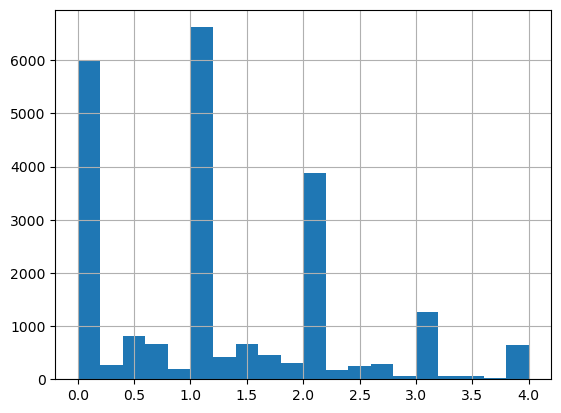

In [31]:
filtered_data['average_rating'] = filtered_data.groupby('file')['rating'].transform('mean')
filtered_data['average_rating'].hist(bins=20)

In [32]:
# example
filtered_data[filtered_data["file"].str.contains("logo_5_")]

,Unnamed: 0,id,file,label,animation_id,model_output,rating,average_rating


### Now pick good Animations only
Pick the following animations
- Best per logo (include as many different logos as possible)
- Add all GOOD animations (additionally add as many animations as possible) TODO: Implement later

In [33]:
filtered_data['include'] = 0

In [34]:
# use all animations with an average rating over 3
minimum_rating = 2
temp = filtered_data['average_rating'] > minimum_rating
filtered_data.loc[temp, 'include'] = 1

In [35]:
print(f"{filtered_data['include'].mean() * 100}% of the data is left out")

12.810757058238575% of the data is left out


In [36]:
# go through each logo to find the best animation
for logo in logos:
    # make a data frame that contains all the animations of one logo
    temp = filtered_data[filtered_data["file"].str.contains(logo)]

    best_logo = temp[temp['average_rating'] == temp['average_rating'].max()]
    best_logo = best_logo['file'].unique()
    
    filtered_data.loc[filtered_data['file'].isin(best_logo), 'include'] = 1
    break

In [37]:
print(f"Now {filtered_data['include'].mean() * 100}% of the data is left out")

Now 12.810757058238575% of the data is left out


Note: No additional animations are selected

In [38]:
best_output = filtered_data[filtered_data['include'] == 1].copy()
best_output.drop(columns=['include'], inplace=True, axis=1)

In [39]:
# extract logo
pattern = r'(logo_\d+)'
best_output['filename'] = best_output['file'].str.extract(pattern)

### Numeration to keep order later (corresponds to start-time)

In [40]:
# # Create a time_offset column filled with zeros
# best_output['a13'] = 0.0

# # Define animation start time offset in seconds from animation start
# TIME_OFFSET_STEP = 0.25

# # Initialize a dictionary to store numbering for each file
# file_counts = {}

# # Iterate through the "file" column and number each unique file
# for index, row in best_output.iterrows():
#     filename = row['file']
#     if filename not in file_counts:
#         file_counts[filename] = 1
#     else:
#         file_counts[filename] += 1
#     best_output.at[index, 'a13'] = file_counts[filename] * TIME_OFFSET_STEP
# best_output.head()

### Stat: Animated paths per logo

In [41]:
used_paths = best_output[["filename", "animation_id"]].drop_duplicates(
    subset = ['filename', 'animation_id'], keep = 'last').reset_index(drop = True)
used_paths.head()

,filename,animation_id
0,logo_0,0
1,logo_0,3
2,logo_0,2
3,logo_1509,1
4,logo_1509,6


array([[<Axes: title={'center': 'animation_id'}>]], dtype=object)

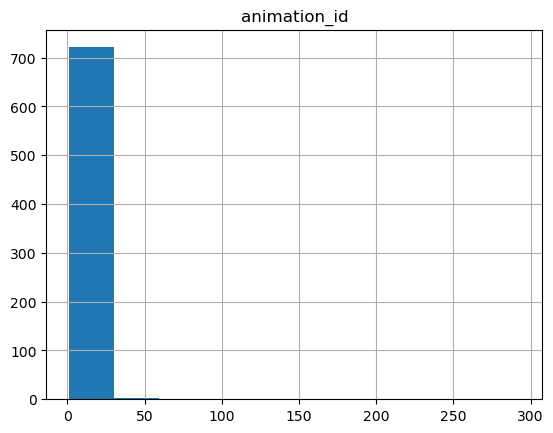

In [42]:
used_paths.groupby(['filename']).count().hist()

### Some Statistics again


In [43]:
grouped = best_output.groupby('file').count()
grouped = grouped[['animation_id']]
print(f"{grouped.size} Animations left over")
histogram_table = grouped['animation_id'].value_counts().reset_index()
histogram_table.columns = ['Animation Length', 'Count']
histogram_table = histogram_table.sort_values(by='Animation Length')
print(histogram_table)

725 Animations left over
    Animation Length  Count
1                  1    159
0                  2    174
2                  3    133
3                  4     93
4                  5     57
5                  6     27
6                  7     22
7                  8     13
8                  9     12
10                10      6
9                 11      6
12                12      4
13                13      3
11                14      4
22                16      1
14                17      3
17                22      1
19                23      1
20                27      1
21                29      1
15                33      2
16                76      1
18               293      1


# Build sequences

## Make List of all Data Samples

### Apply Stats

In [44]:
final_animation_stats = best_output[['filename', 'file', 'model_output']].copy()
final_animation_stats['animation_length'] = 1
for i in range(26):
 final_animation_stats[f'a{i}'] = final_animation_stats['model_output'].apply(lambda x: float(x.split(",")[i].replace("[","").replace("]","")))
final_animation_stats.drop(['model_output'], inplace=True, axis=1)
final_animation_stats

,filename,file,animation_length,a0,a1,a2,a3,a4,a5,a6,...,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25
0,logo_0,logo_0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,logo_0,logo_0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,logo_0,logo_0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,16.888462,18.0,29.0,45.0,99.0,9.0,185.0,7.297494,84.0,0.0
89,logo_1509,logo_1509,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.863407,162.0,-9.0,-13.0,19.0,76.0,106.0,78.105163,70.0,0.0
90,logo_1509,logo_1509,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23018,logo_1123,logo_1123,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
23125,logo_3066,logo_3066,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,19.381105,163.0,-20.0,-14.0,114.0,9.0,11.0,29.595509,98.0,0.0
23126,logo_3066,logo_3066,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
23127,logo_3066,logo_3066,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


### Group by logo & animation

In [45]:
final_animations_index = final_animation_stats.groupby(['filename', 'file']).sum()
#final_animations_index['a0'] = 1 # EOS one per animation sequence
final_animations_index = final_animations_index.reset_index()
final_animations_index

,filename,file,animation_length,a0,a1,a2,a3,a4,a5,a6,...,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25
0,logo_0,logo_0,4,0.0,0.0,2.0,0.0,1.0,0.0,1.0,...,36.390347,115.0,71.0,93.0,181.0,121.0,274.0,14.580848,128.0,0.0
1,logo_1004,logo_1004,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,14.402690,338.0,3.0,4.0,223.0,27.0,201.0,17.948535,48.0,0.0
2,logo_1010,logo_1010,4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,33.443964,376.0,14.0,33.0,496.0,288.0,110.0,213.474650,157.0,0.0
3,logo_1011,logo_1011,2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,3.232327,230.0,-31.0,-4.0,201.0,5.0,130.0,1.167170,43.0,0.0
4,logo_1021,logo_1021,10,0.0,0.0,10.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,logo_960,logo_960,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,26.962563,256.0,-4.0,8.0,241.0,205.0,256.0,98.902850,172.0,0.0
721,logo_963,logo_963,5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,11.865032,51.0,-24.0,34.0,89.0,97.0,54.0,0.168879,74.0,0.0
722,logo_966,logo_966,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,16.423565,401.0,-30.0,-65.0,185.0,354.0,229.0,100.530019,57.0,0.0
723,logo_982,logo_982,2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,9.161843,32.0,47.0,29.0,26.0,48.0,115.0,25.927161,39.0,0.0


### Balance and Oversampling

In [46]:
final_animations_index['repeat'] = 1

def print_balancing_stats(df: pd.DataFrame, silent=False):
    temp = df.copy()
    temp = temp[~temp['filename'].isin(logos_test)] # train data only
    temp = temp.reset_index().drop(['filename', 'file','animation_length'], axis=1)
    for i in range(1, 10):
        temp[f'a{i}'] = temp[f'a{i}'] * temp['repeat']
    balance = temp[['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9']].sum()
    balance_percentage = min(balance) / max(balance)
    balance_diff = max(balance) - min(balance)
    if silent:
        return balance_diff, balance_percentage, balance.nsmallest(10).index
    print(f"Balanced with oversampling {int(temp['repeat'].sum() / len(temp) * 100)-100}% to {int(balance_percentage * 100)}%")
    print(balance)
    
print_balancing_stats(final_animations_index)

Balanced with oversampling 0% to 11%
a1    651.0
a2    916.0
a3    129.0
a4    136.0
a5    125.0
a6    127.0
a7    138.0
a8    102.0
a9    130.0
dtype: float64


In [47]:
print_balancing_stats(final_animations_index, silent=True)

(814.0,
 0.11135371179039301,
 Index(['a8', 'a5', 'a6', 'a3', 'a9', 'a4', 'a7', 'a1', 'a2'], dtype='object'))

Currently, EOS (a0) occurs much more often then the other animation types.

Let's oversample all sequences > 1

In [48]:
final_animations_index[final_animations_index['filename'] == 'logo_2']

,filename,file,animation_length,a0,a1,a2,a3,a4,a5,a6,...,a17,a18,a19,a20,a21,a22,a23,a24,a25,repeat
165,logo_2,logo_2,5,0.0,0.0,2.0,0.0,2.0,0.0,0.0,...,1122.0,-13.0,20.0,562.0,590.0,596.0,143.999281,228.0,0.0,1


Through oversampling, this can be optimized...

In [49]:
# Very fancy sampling
def get_filter_mask(df, rare_animations, second_rarest=False, second_most_frequent=False, max_repetition=8):
    if second_rarest and second_most_frequent:
        return df.loc[(df[rare_animations[0]] > 0) & 
                      (df[rare_animations[1]] > 0) &
                      (df[rare_animations[4]] == 0) &
                      (df[rare_animations[5]] == 0) &
                      (df['repeat'] < df['animation_length'] + 2) &
                      (df['repeat'] < max_repetition)]
    if second_rarest and not second_most_frequent:
        return df.loc[(df[rare_animations[0]] > 0) & 
                      #(df[rare_animations[1]] > 0) &
                      (df[rare_animations[4]] == 0) &
                      (df[rare_animations[5]] == 0) &
                      (df['repeat'] < df['animation_length'] + 2) &
                      (df['repeat'] < max_repetition)]
    if not second_rarest and second_most_frequent:
        return df.loc[(df[rare_animations[0]] > 0) & 
                      (df[rare_animations[1]] > 0) &
                      #(df[rare_animations[4]] == 0) &
                      (df[rare_animations[5]] == 0) &
                      (df['repeat'] < df['animation_length'] + 2) &
                      (df['repeat'] < max_repetition)]
    return df.loc[(df[rare_animations[0]] > 0) & 
                  #(df[rare_animations[1]] > 0) &
                  #(df[rare_animations[4]] == 0) &
                  (df[rare_animations[5]] == 0) &
                  (df['repeat'] < df['animation_length'] + 2) &
                  (df['repeat'] < max_repetition)]

final_animations_index['repeat'] = 1
sample_size = 5

for i in range(500):
    balance_diff, balance, rare_animations = print_balancing_stats(final_animations_index, silent=True)
    if balance_diff < 20:
        sample_size = 1
        filtering = get_filter_mask(final_animations_index, rare_animations, second_most_frequent=True, max_repetition=10)

    else:
        filtering = get_filter_mask(final_animations_index, rare_animations, second_rarest=True, second_most_frequent=True, max_repetition=10)
        if len(filtering == 0):
            filtering = get_filter_mask(final_animations_index, rare_animations, second_most_frequent=True, max_repetition=10)
            if len(filtering == 0):
                filtering = get_filter_mask(final_animations_index, rare_animations, max_repetition=10)
            
    if balance_diff < 20:
        print(f"Final oversampling: {balance_diff} difference, {len(filtering)} in filtering")
    if balance_diff < 2:
        print(f"Break after {i} Iterations")
        break

    random_indices = filtering.sample(n=min(sample_size, len(filtering))).index.tolist()
    final_animations_index.loc[random_indices, 'repeat'] += 1
    
print_balancing_stats(final_animations_index)

Balanced with oversampling 269% to 15%
a1    2835.0
a2    3906.0
a3     619.0
a4     619.0
a5     621.0
a6     617.0
a7     618.0
a8     616.0
a9     618.0
dtype: float64


<Axes: >

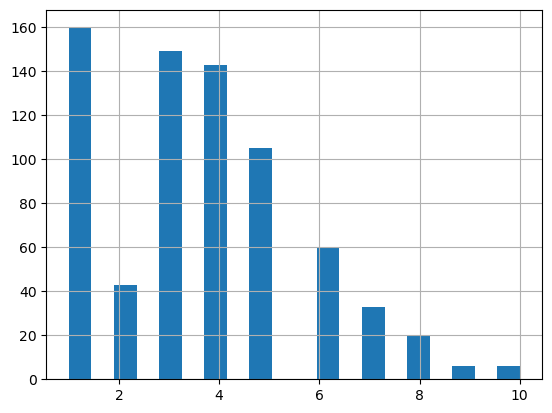

In [50]:
final_animations_index['repeat'].hist(bins=20)

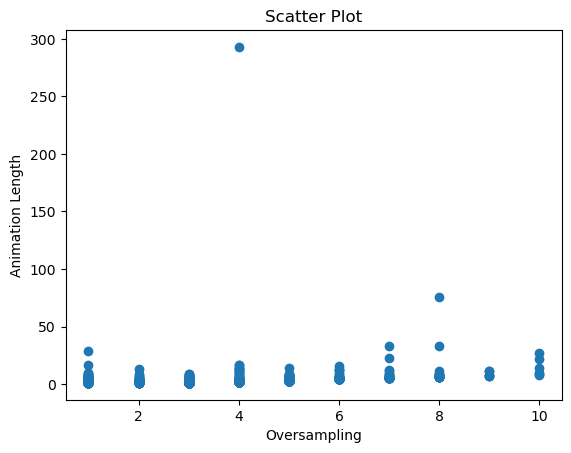

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the two columns for the scatter plot
x = final_animations_index['repeat']
y = final_animations_index['animation_length']

# Create a scatter plot
plt.scatter(x, y)

# Add labels and a title
plt.xlabel('Oversampling')
plt.ylabel('Animation Length')
plt.title('Scatter Plot')

# Show the plot
plt.show()

In [52]:
final_animations_index[final_animations_index['filename'] == 'logo_2']

,filename,file,animation_length,a0,a1,a2,a3,a4,a5,a6,...,a17,a18,a19,a20,a21,a22,a23,a24,a25,repeat
165,logo_2,logo_2,5,0.0,0.0,2.0,0.0,2.0,0.0,0.0,...,1122.0,-13.0,20.0,562.0,590.0,596.0,143.999281,228.0,0.0,5


### Merge logo stats

In [53]:
logos.head()

,filename,count,count_category
0,logo_0,3,Quantile 2
1,logo_1,5,Quantile 8
2,logo_10,7,Quantile 12
3,logo_100,3,Quantile 2
4,logo_1000,4,Quantile 5


In [54]:
final_animations_index = final_animations_index.merge(logos[["filename","count"]], on='filename', how='left')
final_animations_index.rename(columns={'count': 'num_paths'}, inplace=True)
final_animations_index["file"] = final_animations_index["file"].str.replace(".svg","")
final_animations_index

C:\Users\okan2\AppData\Local\Temp\ipykernel_9116\1313802563.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  final_animations_index["file"] = final_animations_index["file"].str.replace(".svg","")


,filename,file,animation_length,a0,a1,a2,a3,a4,a5,a6,...,a18,a19,a20,a21,a22,a23,a24,a25,repeat,num_paths
0,logo_0,logo_0,4,0.0,0.0,2.0,0.0,1.0,0.0,1.0,...,71.0,93.0,181.0,121.0,274.0,14.580848,128.0,0.0,5,3.0
1,logo_1004,logo_1004,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,4.0,223.0,27.0,201.0,17.948535,48.0,0.0,1,4.0
2,logo_1010,logo_1010,4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,14.0,33.0,496.0,288.0,110.0,213.474650,157.0,0.0,6,5.0
3,logo_1011,logo_1011,2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,-31.0,-4.0,201.0,5.0,130.0,1.167170,43.0,0.0,4,4.0
4,logo_1021,logo_1021,10,0.0,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,logo_960,logo_960,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-4.0,8.0,241.0,205.0,256.0,98.902850,172.0,0.0,4,3.0
721,logo_963,logo_963,5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,-24.0,34.0,89.0,97.0,54.0,0.168879,74.0,0.0,7,8.0
722,logo_966,logo_966,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-30.0,-65.0,185.0,354.0,229.0,100.530019,57.0,0.0,3,4.0
723,logo_982,logo_982,2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,47.0,29.0,26.0,48.0,115.0,25.927161,39.0,0.0,1,4.0


### Plot: Number of Paths vs Animation Length

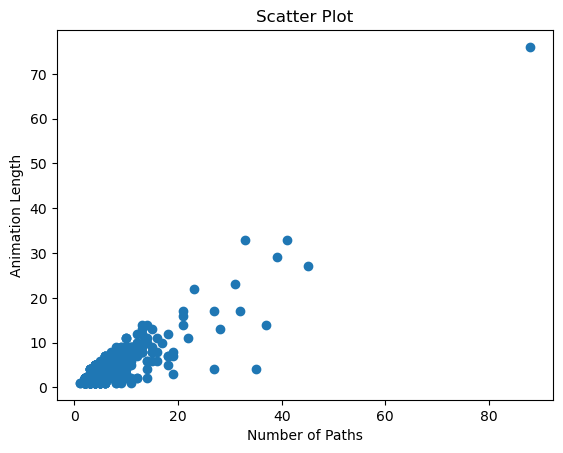

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the two columns for the scatter plot
x = final_animations_index['num_paths']
y = final_animations_index['animation_length']

# Create a scatter plot
plt.scatter(x, y)

# Add labels and a title
plt.xlabel('Number of Paths')
plt.ylabel('Animation Length')
plt.title('Scatter Plot')

# Show the plot
plt.show()

## Bucketing
For batching the data later on, build buckets to group animations with similar length characteristics

In [56]:
# from dataset_helper import generate_buckets_2D
# generate_buckets_2D(final_animations_index,
#                  'count',
#                  'animation_length',
#                  [0.2, 0.4, 0.6, 0.8, 1],
#                  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## Build Input Sequences Dictionary

In [57]:
def build_input_sequences_dict(sequences: pd.DataFrame, used_paths: pd.DataFrame, is_used_path_filtering = False, keep_unused=False):
    initial_length = len(sequences)
    used_paths['animation_id'] = used_paths['animation_id'].astype(str)
    if is_used_path_filtering:
        if keep_unused:
            # If keeping unused paths, perform a left merge and then filter where used paths are NaN
            sequences = pd.merge(sequences, used_paths, on=['filename', 'animation_id'], how='left', indicator=True)
            sequences = sequences[sequences['_merge'] == 'left_only'].drop(columns=['_merge']).copy()
            print(sequences)
            print(f"Filtering of input sequences to keep only unused paths. Reduction from {initial_length} to {len(sequences)} paths.")
        else:
            # If not keeping unused paths, perform an inner merge to keep only used paths
            sequences = pd.merge(sequences, used_paths, on=['filename', 'animation_id']).copy()
            #print(sequences, used_paths)
            print(f"Filtering of input sequences on only used paths. Reduction from {initial_length} to {len(sequences)} paths.")
    
    dict = {}
    for logo in sequences["filename"].unique():
        dict[logo] = sequences[sequences["filename"]==logo]
    #print(dict)
    return dict

In [58]:
input_sequences["filename"] = input_sequences["filename"].str.replace(".svg","")
input_sequences_dict_used = build_input_sequences_dict(input_sequences, used_paths, is_used_path_filtering=True)
print(input_sequences_dict_used.keys())
#input_sequences_dict_used[logos_train[0]]

C:\Users\okan2\AppData\Local\Temp\ipykernel_9116\4019560022.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  input_sequences["filename"] = input_sequences["filename"].str.replace(".svg","")


Filtering of input sequences on only used paths. Reduction from 47271 to 2438 paths.
dict_keys(['logo_2860', 'logo_4587', 'logo_2690', 'logo_3565', 'logo_1400', 'logo_1366', 'logo_3559', 'logo_673', 'logo_1825', 'logo_1979', 'logo_1004', 'logo_2519', 'logo_1010', 'logo_908', 'logo_4626', 'logo_505', 'logo_3411', 'logo_3363', 'logo_3404', 'logo_1207', 'logo_510', 'logo_2242', 'logo_2256', 'logo_1011', 'logo_4169', 'logo_1777', 'logo_3821', 'logo_2281', 'logo_1950', 'logo_2336', 'logo_2322', 'logo_4753', 'logo_3982', 'logo_2478', 'logo_3955', 'logo_896', 'logo_3941', 'logo_3969', 'logo_4579', 'logo_2849', 'logo_2685', 'logo_4592', 'logo_302', 'logo_2861', 'logo_2693', 'logo_328', 'logo_4209', 'logo_24', 'logo_1359', 'logo_2136', 'logo_499', 'logo_664', 'logo_670', 'logo_1167', 'logo_3764', 'logo_4745', 'logo_843', 'logo_4023', 'logo_704', 'logo_1952', 'logo_1749', 'logo_2532', 'logo_506', 'logo_2043', 'logo_1576', 'logo_3361', 'logo_4630', 'logo_4618', 'logo_2269', 'logo_2296', 'logo_318

In [59]:
input_sequences["filename"] = input_sequences["filename"].str.replace(".svg","")
input_sequences_dict_unused = build_input_sequences_dict(input_sequences, used_paths, is_used_path_filtering=True, keep_unused=True)
#input_sequences_dict_unused[logos_train[0]]

C:\Users\okan2\AppData\Local\Temp\ipykernel_9116\1504954084.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  input_sequences["filename"] = input_sequences["filename"].str.replace(".svg","")


      animation_id         0         1         2         3         4  \
4                5 -0.157587  0.536932  0.361361 -0.021343 -0.385152   
6                0 -1.479738  1.499942 -0.460764  0.363093 -0.947988   
7                1  0.813671  0.532380  1.347741  2.284749 -1.111322   
8                3  0.604563 -1.073521  0.185603  0.023935 -0.398406   
9                2  0.826920 -2.444922  0.851283 -0.252141  0.824601   
...            ...       ...       ...       ...       ...       ...   
47266            6 -0.187661  0.401433 -0.100404  0.636203 -0.474901   
47267            7  0.877559 -1.188825  1.372045 -0.126786 -0.186506   
47268            5 -0.833903  0.496440  0.277829  0.364739 -1.040107   
47269            4 -0.400199  0.921548  0.191972  0.333160 -1.018423   
47270            8  0.877559 -1.188825  1.372045 -0.126786 -0.186506   

              5         6         7         8  ...       247       248  \
4      0.616863 -0.865314  0.770734 -0.353508  ... -1.172260 

## Build Output Sequence (Embedded Paths with Animation Vector)

In [60]:
# Merge Dataframes
output_sequence = pd.merge(best_output, embeddings, on=['filename', 'animation_id'], how='inner')
animation_vectors=pd.DataFrame()
for i in range(26):
 animation_vectors[f'a{i}'] = output_sequence['model_output'].apply(lambda x: float(x.split(",")[i].replace("[","").replace("]","")))
#animation_vectors = pd.DataFrame(output_sequence["model_output"].to_list(), columns=["a1","a2","a3","a4","a5","a6","a7","a8","a9","a10","a11","a12"])
output_sequence.drop(['animation_id', 'model_output', 'label', 'rating', 'average_rating'], inplace=True, axis=1)
#output_sequence['a0'] = 0 # EOS Feature in One-hot Encoding
output_sequence = pd.merge(output_sequence, animation_vectors, left_index=True, right_index=True)
output_sequence["file"] = output_sequence["file"].str.replace(".svg","")

C:\Users\okan2\AppData\Local\Temp\ipykernel_9116\911588775.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  output_sequence["file"] = output_sequence["file"].str.replace(".svg","")


In [61]:
# Move column 'a13' to the back
column_to_move = 'a10'
new_order = [col for col in output_sequence.columns if col != column_to_move]
new_order.append(column_to_move)
#output_sequence = output_sequence[new_order]

In [62]:
output_sequence.head()

,Unnamed: 0,id,file,filename,0,1,2,3,4,5,...,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25
0,0,0,logo_0,logo_0,-1.479738,1.499942,-0.460764,0.363093,-0.947988,-1.115443,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,2,0,logo_0,logo_0,-0.094627,1.475891,-0.203824,0.158015,-0.299620,0.895283,...,16.888462,18.0,29.0,45.0,99.0,9.0,185.0,7.297494,84.0,0.0
2,1022,5,logo_1509,logo_1509,0.888646,0.856151,0.463442,2.081298,-0.599237,-2.067103,...,9.863407,162.0,-9.0,-13.0,19.0,76.0,106.0,78.105163,70.0,0.0
3,1023,5,logo_1509,logo_1509,-0.178775,-0.420255,0.681953,0.106935,0.925431,-0.286306,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,1024,5,logo_1509,logo_1509,-1.479738,1.499942,-0.460764,0.363093,-0.947988,-1.115443,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


## Main Iteration over all samples

In [63]:
from dataset_helper import generate_dataset


dataset = generate_dataset(final_animations_index,
                           input_sequences_dict_used,
                           input_sequences_dict_unused,
                           output_sequence,
                           {"train": logos_train, "test": logos_test},
                           sequence_length_input=95, # low as filtered
                           sequence_length_output=95, # input + SOS / EOS
                           )
# Executed in 1 minute with shortened padding ~Cornelius

Processing logo_0 with logo_0: 
Processing logo_1004 with logo_1004: 
Processing logo_1010 with logo_1010: 
Processing logo_1011 with logo_1011: 
Processing logo_1021 with logo_1021: 
Processing logo_1037 with logo_1037: 
Processing logo_104 with logo_104: 
Processing logo_1043 with logo_1043: 
Processing logo_1044 with logo_1044: 
Processing logo_1058 with logo_1058: 
Processing logo_107 with logo_107: 
Processing logo_108 with logo_108: 
Processing logo_1080 with logo_1080: 
Processing logo_1085 with logo_1085: 
Processing logo_1099 with logo_1099: 
Processing logo_1107 with logo_1107: 
Processing logo_1108 with logo_1108: 
Processing logo_1122 with logo_1122: 
Processing logo_1123 with logo_1123: 
Processing logo_1127 with logo_1127: 
Processing logo_1130 with logo_1130: 
Processing logo_1132 with logo_1132: 
Processing logo_1139 with logo_1139: 
Processing logo_1145 with logo_1145: 
Processing logo_1149 with logo_1149: 
Processing logo_1154 with logo_1154: 
Processing logo_1159 wit

## Result

In [64]:
torch.save(dataset["train"]["input"], 'data/prototype_dataset/train_sequence_input.pt')
torch.save(dataset["train"]["output"], 'data/prototype_dataset/train_sequence_output.pt')
torch.save(dataset["test"]["input"], 'data/prototype_dataset/test_sequence_input.pt')
torch.save(dataset["test"]["output"], 'data/prototype_dataset/test_sequence_output.pt')

In [65]:
print(dataset["train"]["input"].size())
print(dataset["train"]["output"].size())
print(dataset["test"]["input"].size())
print(dataset["test"]["output"].size())

torch.Size([1645, 95, 282])
torch.Size([1645, 95, 282])
torch.Size([109, 95, 282])
torch.Size([109, 95, 282])
